# 【問題1】線形回帰のクラスを作成する
###### 線形回帰のクラスを作成し、Sprint2で作成した回帰のパイプラインに組み込んでください。
###### 以下が雛形です。ここにメソッドを加えていってください。メソッドやパラメータなどはscikit-learnを参考にしてください。
###### sklearn.linear_model.LinearRegression — scikit-learn 0.20.0 documentation
###### 検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

<指針>  
* 線形回帰であるため、fit内では常に標準化を実施し、予測値を出す段階では標準化して扱ったデータを逆変換して元の単位に戻す仕組みとする。  
（前処理で標準化がなされていて二重処理となっても問題はおこらない。）  

* 特徴量選択、削減、追加などの処理が有効かどうかは、分析ケースに依存するため、Classには入れ込まない。  
（実施するか引数を入力する仕組みならあり？）　　

* biasの処理については問題３ですが、先にClass埋め込んでおきました。

In [23]:
#クラスの中に入れても動作しないので、忘れずにセルの先頭にまとめて入れておく。 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter=500, lr=0.01, bias=True, verbose=False): 
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        


    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

            
        #　bias を含める場合、全てのサンプルにx0=1を追加
        if self.bias == True:
            X = np.hstack([np.c_[np.ones(X.shape[0])],np.c_[X]])
            if (X_val is not None) and (y_val is not None): #　検証データがある場合もバイアス項を含めるため、全てのサンプルにx0=1を追加
                X_val = np.hstack([np.c_[np.ones(X_val.shape[0])],np.c_[X_val]]) 
    
        #X,yの標準化を行う
        X_mean = X.mean(axis=0, keepdims=True) #Xの平均値を作成
        X_std = np.std(X, axis=0, keepdims=True) #Xの標準偏差を作成
        X_stded = (X-X_mean)/X_std #Xの標準化データを作成する
        X_stded[:,0] = 1 # 全て１のデータに対して標準化を行うとNANになってしまうので再度１を挿入
        y_mean = y.mean(axis=0, keepdims=True) #yの平均値を作成
        y_std  = np.std(y, axis=0, keepdims=True) #yの標準偏差を作成
        y_label_stded= (y-y_mean)/y_std #yの標準化データを作成する
        
        
        #X_val,y_valがあれば標準化を行う
        if (X_val is not None) and (y_val is not None): 
            #X_val,y_valの標準化を行う
            X_val_mean = X_val.mean(axis=0, keepdims=True) #Xの平均値を作成
            X_val_std  = np.std(X_val, axis=0, keepdims=True) #Xの標準偏差を作成
            X_val_stded= (X_val-X_val_mean)/X_val_std #Xの標準化データを作成する
            X_val_stded[:,0] = 1 # 全て１のデータに対して標準化を行うとNANになってしまうので再度１を挿入
            y_val_mean = y_val.mean(axis=0, keepdims=True) #yの平均値を作成
            y_val_std  = np.std(y_val, axis=0, keepdims=True) #yの標準偏差を作成
            y_val_label_stded= (y_val-y_val_mean)/y_val_std #yの標準化データを作成する        
        
        
        # coef_初期値を全ての重みが１となるように作成
        self.coef_ = np.ones(X_stded.shape[1])
    
    
        #最急勾配降下法を実施
        for i in range(self.iter):
            y_pred_temp = np.dot(X_stded, self.coef_) #試行回数時点のthetaにおける予測値
            y_val_pred_temp = np.dot(X_val_stded, self.coef_) #試行回数時点のthetaにおけるy_val予測値
            self.coef_ = self.coef_ - self.lr * (np.dot((y_pred_temp - y_label_stded) , X_stded) / X_stded.shape[0]) #重み更新
            self.loss[i] = ((y_pred_temp - y_label_stded)**2).mean() #学習データの損失関数MSEスコア
            self.val_loss[i] = ((y_val_pred_temp - y_val_label_stded)**2).mean() #検証データのMSEスコア
            
            
        # fit段階で設定したパラメータtheta,X_mean,X_std,y_mean,y_stdを記録
        self.final_coef_ = self.coef_
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.val_loss)

    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        #　bias を含める場合、全てのサンプルにx0=1を追加
        if self.bias == True:
            X = np.hstack([np.c_[np.ones(X.shape[0])],np.c_[X]])  
        
        #訓練データの数値を使って標準化を行う
        X_stded= (X-self.X_mean)/self.X_std #学習データの数値を使って標準化データを作成する
        X_stded[:,0] = 1 # 全て１のx0データに対して標準化を行うとNANになってしまうので再度１を挿入
        
        
        #最急勾配効果法を完了した時点でのthetaを使って標準化した場合のｙ_predを予測する
        y_pred_stded = np.dot(X_stded, self.final_coef_)
        
        #訓練データの数値を使ってy_pred_stdをy_predに逆変換
        y_pred = y_pred_stded * self.y_std + self.y_mean
        
        return y_pred

    def loss_graph(self):
        
        #損失関数の遷移
        plt.figure(figsize=(4, 3), dpi=200)
        plt.title('model loss')
        plt.xlabel('iter')
        plt.ylabel('MSE')
        plt.plot(self.val_loss, color='red',label = "val_loss",linewidth=1,linestyle='solid')
        plt.plot(self.loss, color='blue',label = "train_loss",linewidth=1,linestyle='dashed')
        plt.legend()
    
    
    

# 【問題2】学習曲線のプロット
###### まず、学習曲線を表示する関数を作成してください。
###### 線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。

→model.loss_graph()という関数をclassに埋め込みました

In [25]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
import random
 
#データセットを読み込み、作成
df = pd.read_csv('house_price_dataset_train.csv')
X = df.loc[:,['GrLivArea','YearBuilt']].values
y = df.loc[:,'SalePrice'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
#l_regressorを作成してフィッティング
l_regressor = ScratchLinearRegression(bias=True)
l_regressor.fit(X_train,y_train,X_val,y_val)

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


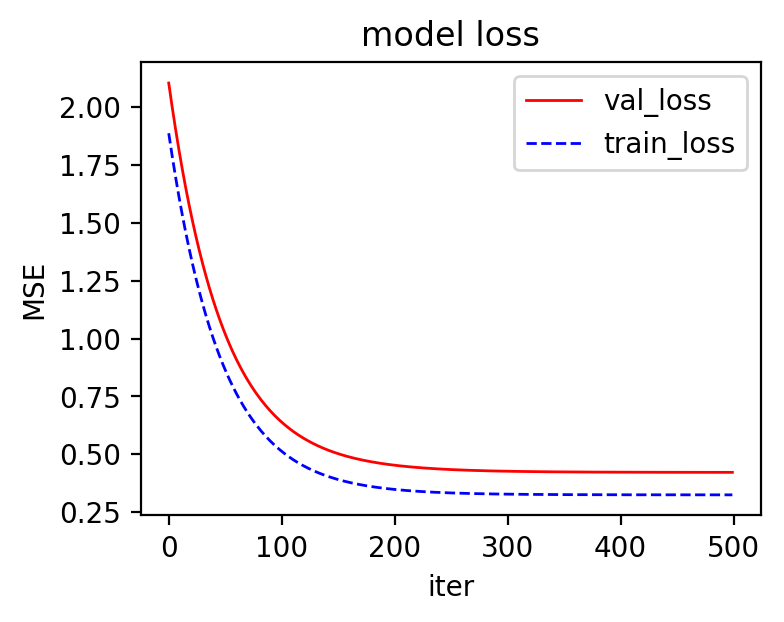

In [27]:
l_regressor.loss_graph()

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide


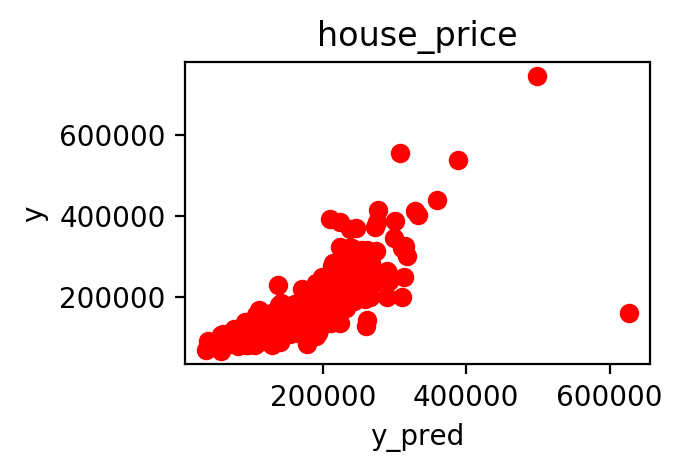

In [28]:
#予測価格と実態価格のスコア表示
#データフレーム に格納
df_pred = pd.DataFrame()
df_pred ['y_pred']= l_regressor.predict(X_val)
df_pred ['y_val']= y_val

#予測価格と実態価格のスコアをグラフ化
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 2), dpi=200)
plt.title('house_price')
plt.xlabel('y_pred')
plt.ylabel('y')
plt.scatter(df_pred ['y_pred'],df_pred ['y_val'], color='red',label = "bias_val_loss")

# 【問題3】（アドバンス課題）バイアス項の除去
###### バイアス項を抜くと学習がどう変化するか検証してください。
###### また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。

→バイアスを含めるか判定して回帰を行うCLASSとしました

In [29]:
#lバイアスありのregressorを作成し、MSEの推移を確認
l_regressor_bias = ScratchLinearRegression(bias=True,verbose=True,num_iter=100,lr=0.01)
l_regressor_bias .fit(X_train,y_train,X_val,y_val)

[2.10428449 2.06949359 2.03543409 2.00209041 1.96944729 1.93748981
 1.90620337 1.87557369 1.84558679 1.81622899 1.7874869  1.75934744
 1.73179779 1.70482541 1.67841803 1.65256365 1.62725053 1.60246716
 1.57820231 1.55444497 1.53118437 1.50840997 1.48611145 1.46427874
 1.44290196 1.42197144 1.40147774 1.38141159 1.36176395 1.34252595
 1.32368893 1.3052444  1.28718407 1.2694998  1.25218365 1.23522784
 1.21862474 1.20236692 1.18644708 1.17085809 1.15559295 1.14064485
 1.12600709 1.11167312 1.09763654 1.08389109 1.07043062 1.05724914
 1.04434077 1.03169976 1.01932048 1.00719743 0.99532521 0.98369855
 0.97231229 0.96116138 0.95024086 0.9395459  0.92907177 0.91881383
 0.90876753 0.89892845 0.88929222 0.87985461 0.87061144 0.86155865
 0.85269223 0.84400829 0.83550302 0.82717266 0.81901356 0.81102213
 0.80319487 0.79552835 0.78801921 0.78066415 0.77345997 0.7664035
 0.75949167 0.75272146 0.74608991 0.73959414 0.7332313  0.72699864
 0.72089343 0.71491303 0.70905483 0.70331629 0.69769492 0.69218

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


In [30]:
#lバイアスなしのregressorを作成し、MSEの推移を確認
l_regressor_non_bias = ScratchLinearRegression(bias=False,verbose=True,num_iter=100,lr=0.01)
l_regressor_non_bias .fit(X_train,y_train,X_val,y_val)

[1.93668415 1.91232262 1.88844687 1.86504722 1.8421142  1.81963851
 1.79761102 1.77602283 1.75486516 1.73412946 1.71380731 1.69389047
 1.67437087 1.65524059 1.63649188 1.61811714 1.60010891 1.58245989
 1.56516293 1.54821101 1.53159726 1.51531494 1.49935745 1.4837183
 1.46839117 1.45336983 1.4386482  1.42422029 1.41008025 1.39622236
 1.38264098 1.36933061 1.35628585 1.3435014  1.33097208 1.3186928
 1.30665858 1.29486453 1.28330588 1.27197792 1.26087606 1.2499958
 1.23933271 1.22888247 1.21864084 1.20860366 1.19876686 1.18912643
 1.17967847 1.17041914 1.16134468 1.15245141 1.14373571 1.13519404
 1.12682294 1.118619   1.1105789  1.10269936 1.09497719 1.08740924
 1.07999245 1.0727238  1.06560033 1.05861916 1.05177744 1.04507239
 1.0385013  1.03206148 1.02575032 1.01956526 1.01350378 1.00756342
 1.00174176 0.99603644 0.99044512 0.98496555 0.9795955  0.97433277
 0.96917523 0.96412078 0.95916736 0.95431297 0.94955562 0.94489338
 0.94032434 0.93584667 0.93145852 0.92715811 0.9229437  0.9188135

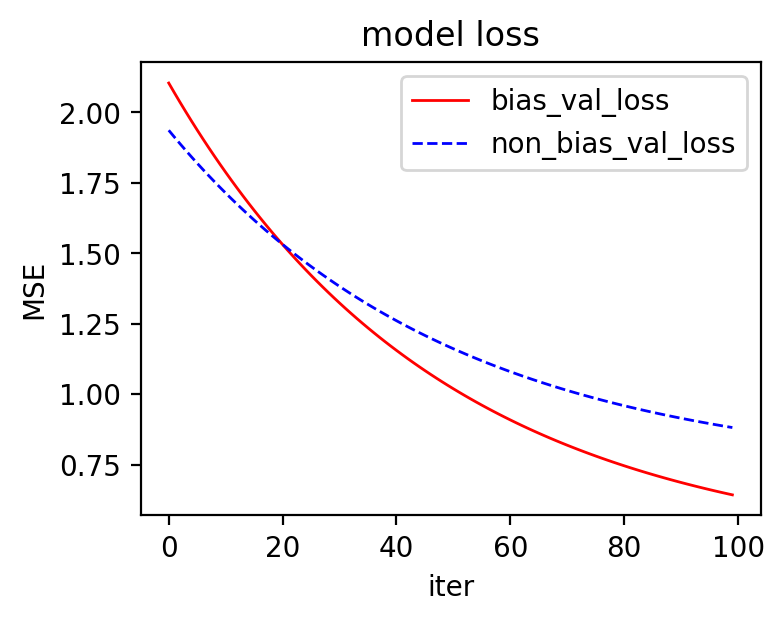

In [31]:
import matplotlib.pyplot as plt
#各モデルの損失関数の推移
plt.figure(figsize=(4, 3), dpi=200)
plt.title('model loss')
plt.xlabel('iter')
plt.ylabel('MSE')
plt.plot(l_regressor_bias.val_loss, color='red',label = "bias_val_loss",linewidth=1,linestyle='solid')
plt.plot(l_regressor_non_bias.val_loss, color='blue',label = "non_bias_val_loss",linewidth=1,linestyle='dashed')
plt.legend()

→バイアスがある方は、重みの数が増えたことにより最初は検証MSEスコアが負けていたが、

学習による改善が顕著で、重み更新が20回を超えたあたりから逆転して、最終的にスコア優位性が出た。

## 【考察】

### ■バイアス項によりモデル精度は高まる場面が多いと思われる。

（⓪モデルが複雑化すると、実態との当てはまりが良くなる傾向？）

#### <font color="red">①データ化されていない説明変数をモデルで表現する手段の１つなるのではないか。</font>

#### <font color="red">②特に重要な説明変数がデータとして手元に不足している場合、重み絶対値の係数和を抑える効果。</font>

#### <font color="red">③予測したい目標のベースラインを表現できる。</font>

→予測したい指標に因果関係を持つ説明変数が全てデータ化されている、手に入ることはあり得ない。しかし、手元にない因子を総括りでモデルに反映させることができる。

例えば、ディズニーランドの入園者数の来園理由推測分析では、  
定量のみの分析において「原因不明」の部分が3割以上あると聞いたことがあり、  
当然一切のマーケティング活動をやめた時期にも入園者数は急激に減ることはなかった。  
過去に築いたブランド資産や来園習慣（データ化が困難な変数）が入園者数のベースラインを担保している。

今回の住宅価格予測においても、直接的ではないが、使用していない、データ化されていない説明変数を反映させていると思われる。

# 【問題4】（アドバンス課題）特徴量の多次元化
###### 特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。

### ①特徴量の2乗を新たに追加

In [32]:
X = df.loc[:,['GrLivArea','YearBuilt']].values
y = df.loc[:,'SalePrice'].values

#Xに関しては特徴量の2乗を新たに追加してX_newに。
X_square = X**2
X_new = np.concatenate([X,X_square], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.2, random_state=0)

In [33]:
#lregressor_add_sauqreを作成
l_regressor_add_square = ScratchLinearRegression(bias=True)
l_regressor_add_square.fit(X_train, y_train, X_val, y_val)

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


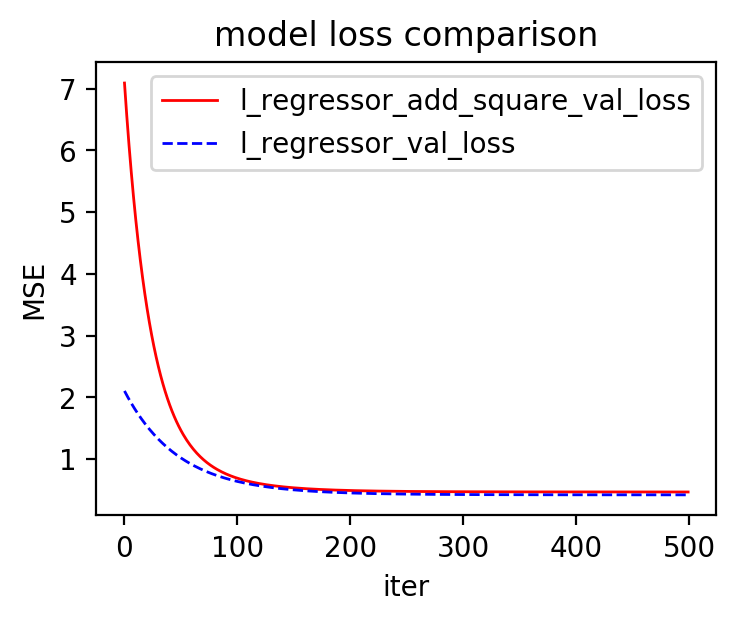

In [34]:
#各モデルの損失関数の推移
plt.figure(figsize=(4, 3), dpi=200)
plt.title('model loss comparison')
plt.xlabel('iter')
plt.ylabel('MSE')
plt.plot(l_regressor_add_square.val_loss, color='red',label = "l_regressor_add_square_val_loss",linewidth=1,linestyle='solid')
plt.plot(l_regressor.val_loss, color='blue',label = "l_regressor_val_loss",linewidth=1,linestyle='dashed')
plt.legend()

→多重共線性、特徴量の増加により、更新初期の段階ではMSEスコアが急激に悪化した。  
しかし、更新１００回を超えたあたりからほぼ同じスコアとなった。

### ①'特徴量の２乗のみを入力に利用

In [35]:
X = df.loc[:,['GrLivArea','YearBuilt']].values
y = df.loc[:,'SalePrice'].values

#Xに関しては特徴量の2乗を新たに追加してX_newに。
X_square = X**2
X_new = X_square 
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.2, random_state=0)

In [36]:
#lregressor_add_sauqreを作成
l_regressor_square = ScratchLinearRegression(bias=True)
l_regressor_square.fit(X_train, y_train, X_val, y_val)

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


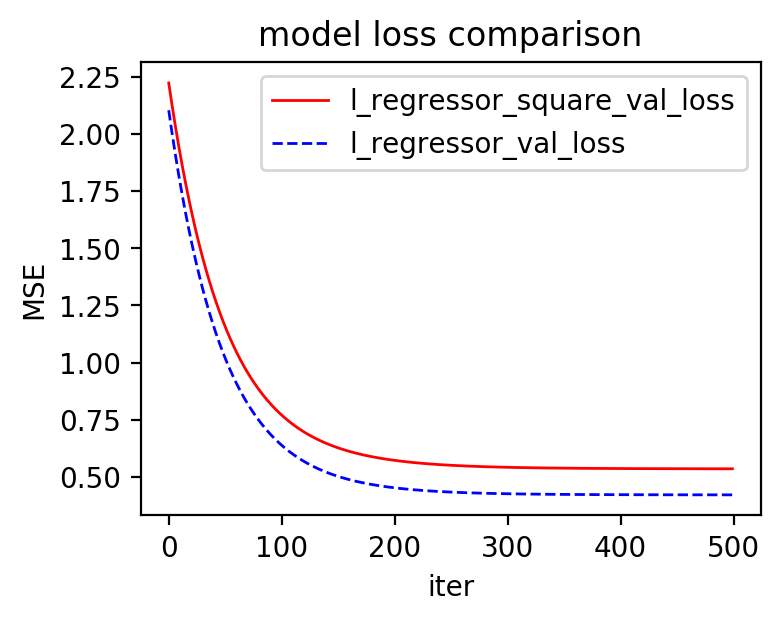

In [37]:
#各モデルの損失関数の推移
plt.figure(figsize=(4, 3), dpi=200)
plt.title('model loss comparison')
plt.xlabel('iter')
plt.ylabel('MSE')
plt.plot(l_regressor_square.val_loss, color='red',label = "l_regressor_square_val_loss",linewidth=1,linestyle='solid')
plt.plot(l_regressor.val_loss, color='blue',label = "l_regressor_val_loss",linewidth=1,linestyle='dashed')
plt.legend()

→特徴量を2乗しただけのデータを入力した場合、大きくスコアが悪化している。

### ②特徴量の3乗を新たに追加

In [38]:
#データセットを設定
X = df.loc[:,['GrLivArea','YearBuilt']].values
y = df.loc[:,'SalePrice'].values

#Xに関しては特徴量の3乗を新たに追加してX_newに。
X_cube = X**3
X_new = np.concatenate([X,X_cube], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.2, random_state=0)

In [39]:
#lregressor_add_sauqreを作成
l_regressor_add_cube = ScratchLinearRegression(bias=True)
l_regressor_add_cube.fit(X_train, y_train, X_val, y_val)

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


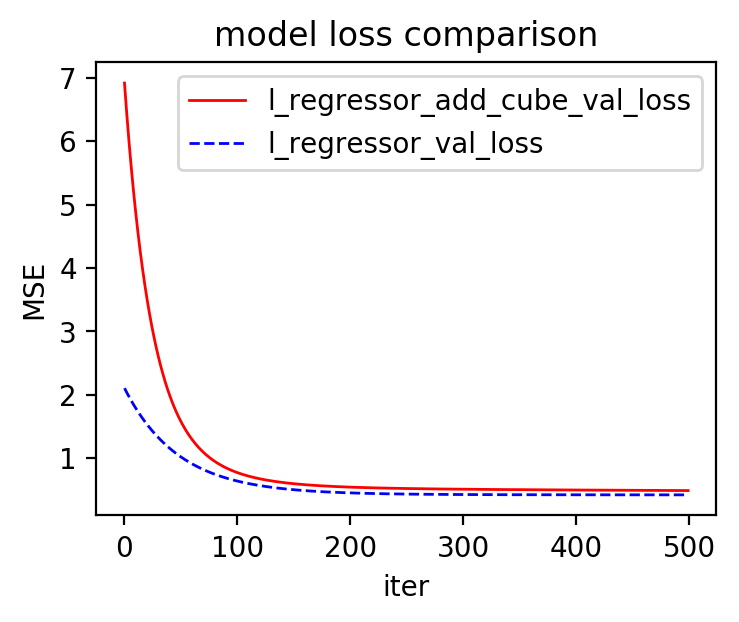

In [40]:
#各モデルの損失関数の推移
plt.figure(figsize=(4, 3), dpi=200)
plt.title('model loss comparison')
plt.xlabel('iter')
plt.ylabel('MSE')
plt.plot(l_regressor_add_cube.val_loss, color='red',label = "l_regressor_add_cube_val_loss",linewidth=1,linestyle='solid')
plt.plot(l_regressor.val_loss, color='blue',label = "l_regressor_val_loss",linewidth=1,linestyle='dashed')
plt.legend()

→Xの2乗の特徴量を追加した時と同じく、更新初期の段階ではMSEスコアが急激に悪化し（MSE>80）、  
Xの２乗の時よりも改善が緩やか、かつ500回実施時点での最終MSEスコアもXの２乗の時より悪い。

### ②'特徴量の３乗のみを入力に利用

In [41]:
X = df.loc[:,['GrLivArea','YearBuilt']].values
y = df.loc[:,'SalePrice'].values

#Xに関しては特徴量の2乗を新たに追加してX_newに。
X_new = X**3
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.2, random_state=0)

In [42]:
#lregressor_add_sauqreを作成
l_regressor_cube = ScratchLinearRegression(bias=True)
l_regressor_cube.fit(X_train, y_train, X_val, y_val)

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


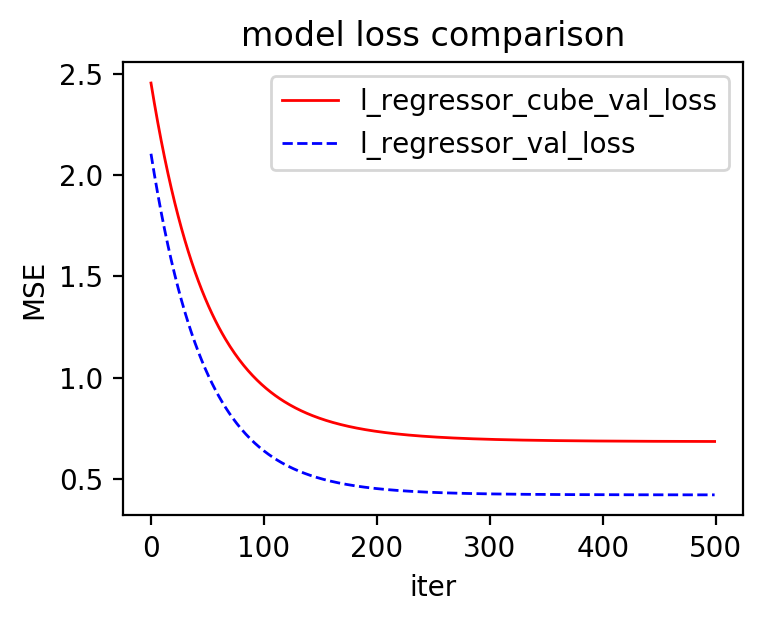

In [43]:
#各モデルの損失関数の推移
plt.figure(figsize=(4, 3), dpi=200)
plt.title('model loss comparison')
plt.xlabel('iter')
plt.ylabel('MSE')
plt.plot(l_regressor_cube.val_loss, color='red',label = "l_regressor_cube_val_loss",linewidth=1,linestyle='solid')
plt.plot(l_regressor.val_loss, color='blue',label = "l_regressor_val_loss",linewidth=1,linestyle='dashed')
plt.legend()

→特徴量を３乗しただけのデータを入力した場合、大きくスコアが悪化している。

### ③全ての特徴量の活性化関数としてシグモイド関数をかませる
正則化項を作る以外で線形回帰を改良できないか？

In [44]:
#データセットを設定
#データセットを設定
X = df.loc[:,['GrLivArea','YearBuilt']].values
y = df.loc[:,'SalePrice'].values

#Xに関して標準化したのちにシグもイド関数をかませてX_newに。
import math

#X,yの標準化を行う
X_stded = (X-X.mean(axis=0, keepdims=True))/np.std(X, axis=0, keepdims=True) #Xの標準化データを作成する
X_stded[:,0] = 1 # 全て１のデータに対して標準化を行うとNANになってしまうので再度１を挿入


X_std_sigmoid = 1 / (1 + math.e**-X_stded)
#X_new = np.concatenate([X_stded,X_std_sigmoid], axis=1)
X_new = X_std_sigmoid
X_train, X_val,y_train , y_val = train_test_split(X_new, y, test_size=0.2, random_state=0)

In [45]:
#lregressor_add_sigmoidを作成
l_regressor_add_sigmoid = ScratchLinearRegression(bias=True)
l_regressor_add_sigmoid.fit(X_train,y_train,X_val, y_val)

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


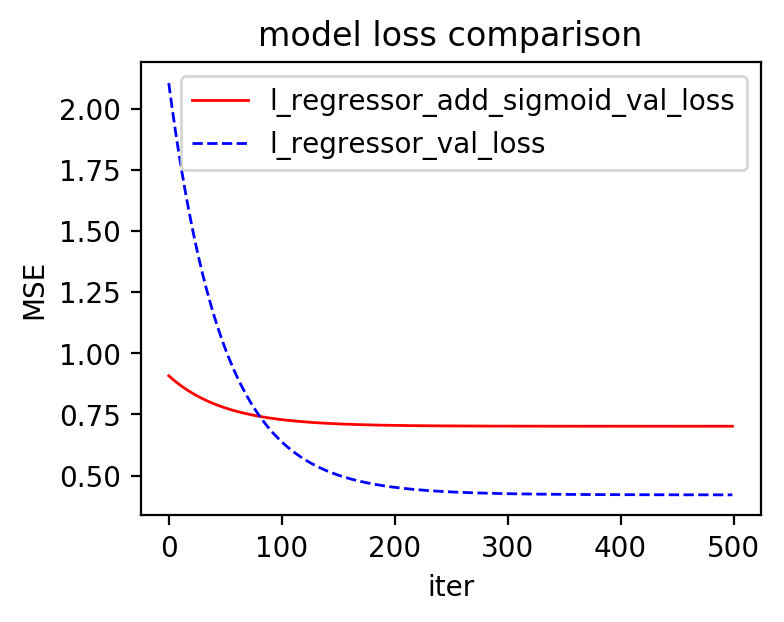

In [46]:
#各モデルの損失関数の推移
plt.figure(figsize=(4, 3), dpi=200)
plt.title('model loss comparison')
plt.xlabel('iter')
plt.ylabel('MSE')
plt.plot(l_regressor_add_sigmoid.val_loss, color='red',label = "l_regressor_add_sigmoid_val_loss",linewidth=1,linestyle='solid')
plt.plot(l_regressor.val_loss, color='blue',label = "l_regressor_val_loss",linewidth=1,linestyle='dashed')
plt.legend()

# 【問題5】（アドバンス課題）更新式の導出
###### 最急降下法の更新式は以下でした。この式が導出される過程を説明してください。

※数式をjupyter notebookに書く方法を調べておく。

###### <解答>  
損失関数のある地点のxから、その地点における傾きを引いた値は、頂点を飛び越えない限り損失関数を小さくすることにつながる。  
しかし、「損失関数の値」と「傾きの値」の単位の縮尺は異なるため、  
傾きを引いていってもxの変化、ひいては損失関数の変化が小さくなる場合がある。  
また、逆に大きすぎて頂点を飛び越えることがある。  
よってxの学習率:αを掛け合わせることでxの変化の縮尺をコントロールする。  

$$
    % パラメータの更新関数
    θj = θj - \frac{∂}{∂θ}J(θ) \\
    % パラメータの更新関数
$$

# 【問題6】（アドバンス課題）局所最適解の問題
###### 最急降下法には一般的に局所最適解の問題があります。しかし、線形回帰では学習を続ければ必ず最適解を求めることができます。それはなぜか数式やグラフを用いて説明してください。

###### <解答>  
今回の線形回帰で設定した損失関数は、あるθを見た場合に２次関数（下に凸な放物線）である。
損失関数はxの２次関数、損失関数の傾きは常にxの１次関数、2回微分を行うと定数になる。

よって、Xを正の方向に移動させると損失関数の傾きは常に正の方向に変化、
Xを負の方向に移動させると損失関数の傾きは常に負の方向に変化という状況であるため、
傾き*学習率を重みから引いてゆけば、最終的には放物線の頂点に落ち着くことになる。

# 【問題7】スクラッチで学べることは何か
###### 最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

#### <意見>
<li>原理を理解できるようになり、引数に対する意識の比重が高くなる。